<a href="https://colab.research.google.com/github/MathieuGrosso/projet-dima-/blob/main/extracting_features_EfficientNetB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print(sys.version)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE, Isomap, MDS

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers.experimental import preprocessing
import cv2

from tensorflow.keras.utils import to_categorical

3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]


#Load Data 

11493376/11490434 [==============================] - 0s 0us/step


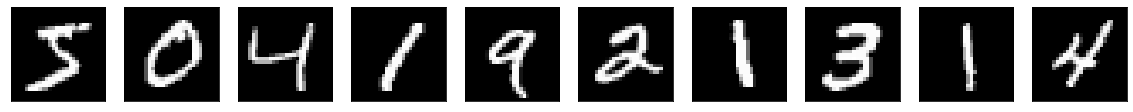

In [ ]:
#import data of mnist and fashion mnist: 
dataset = "numbers" # "numbers" or "fashion"
anomaly_class = 8  # indicates which class is considered as anomalous

if dataset == "numbers":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    dico = {
            0: '0',
            1: '1',
            2: '2',
            3: '3',
            4: '4',
            5: '5',
            6: '6',
            7: '7',
            8: '8',
            9: '9',
    }
elif dataset =="fashion":
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    dico = {
            0: 'T-shirt/top',
            1: 'Trouser/pants',
            2: 'Pullover shirt',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot',
    }
else:
    print("Error: choices are 'fashion' or 'numbers'")

#We only keep normal images in the training set
#J'ai enlevé ces deux lignes pour le moment pour essayer de déjà faire marcher l'algo en version supervised
x_train = x_train[y_train != anomaly_class]
y_train = y_train[y_train != anomaly_class]

# Normalization and shape configuration
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# Display some NORMAL images
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
print(x_train.shape, 'x train samples')
print(x_test.shape, 'x test samples')
print(y_train.shape, 'y train samples')
print(y_test.shape, 'y test samples')

(54149, 28, 28, 1) x train samples
(10000, 28, 28, 1) x test samples
(54149,) y train samples
(10000,) y test samples


#Preprocessing the data: 


In [ ]:
#change the format of MNIST DATA : 

x_train_rgb, x_test_rgb = np.squeeze(x_train,axis=3), np.squeeze(x_test,axis=3) #(54149,28,28)
print(x_train_rgb.shape)
print(x_test_rgb.shape)


(54149, 28, 28)
(10000, 28, 28)


In [ ]:
#Repeat the image array 3 times on a new dimension 
x_train_rgb, x_test_rgb = np.repeat(x_train_rgb[..., np.newaxis], 3, -1), np.repeat(x_test_rgb[..., np.newaxis], 3, -1)


In [ ]:
print(x_train_rgb.shape)
print(x_test_rgb.shape)

(54149, 28, 28, 3)
(10000, 28, 28, 3)


NameError: ignored

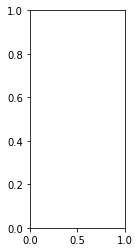

In [ ]:
import cv2
import numpy as np


#n=x_test_rgb.shape[0]
n=250
image_test=[]
for i in range(n):
  new_image_test = cv2.resize(x_test_rgb[i], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
  image_test.append(new_image_test)
  x_test=np.array(image_test)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

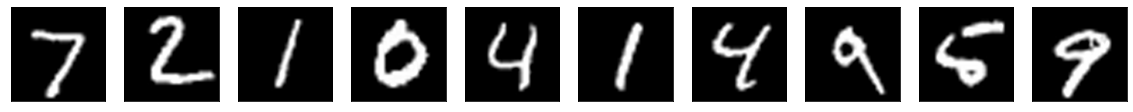

In [ ]:
plt.figure(figsize=(20, 4))
m=10
for i in range(m):
    # display original
    ax = plt.subplot(1, m, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()


In [ ]:
print(x_test.shape)

(250, 380, 380, 3)


#Load model and extract the feature maps: 

In [ ]:

#loading the EfficientNet model: 
from tensorflow.keras.applications import EfficientNetB4
base_model = EfficientNetB4(weights='imagenet',include_top=False)
print(base_model.summary())

71688192/71686520 [==============================] - 1s 0us/step
Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
____________________

In [ ]:
#extraire le premier niveau 

from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential
import numpy as np
import os

prev_model=Model(inputs=base_model.input, outputs=base_model.get_layer('block1b_add').output) #loading the 1st block of the previously saved model 

block1_pool_features = Sequential()
block1_pool_features.add(prev_model)
block1_pool_features.add(GlobalAveragePooling2D())
block1_pool_features.compile()

block1_pool_features.summary()
block1_pool_features=block1_pool_features.predict(x_test)
print(block1_pool_features.shape)
print(block1_pool_features)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, None, None, 24)    5881      
_________________________________________________________________
global_average_pooling2d_2 ( (None, 24)                0         
Total params: 5,881
Trainable params: 5,538
Non-trainable params: 343
_________________________________________________________________
(250, 24)
[[ 1.4635324   0.00861125 -0.71892434 ...  5.2617054   2.2105136
   4.762001  ]
 [ 1.4636385   0.0086343  -0.7182717  ...  5.262479    2.2094219
   4.761701  ]
 [ 1.463434    0.0086158  -0.71897095 ...  5.2611165   2.211374
   4.7621813 ]
 ...
 [ 1.4635812   0.00862133 -0.71865207 ...  5.261577    2.2100618
   4.7616434 ]
 [ 1.4638174   0.00862188 -0.71803284 ...  5.2622433   2.2089307
   4.761424  ]
 [ 1.4634827   0.00862108 -0.7189032  ...  5.261721    2.2105174
   4.761898  ]]


On a obtenu un vecteur. Ce vecteur sera considéré comme une représentation de l'image d'entrée.

Dans cet espace de  représentation on va utiliser la distance de mahalanobis pour évaluer le dégré d'anomalie de chaque image. 


# calcul de la distance de mahalanobis dans chaque espace de representation: 


In [25]:
# Using Mahalanobis Distance as Anomaly Detector
from sklearn.covariance import EmpiricalCovariance
emp_cov = EmpiricalCovariance().fit(block1_pool_features) #calcul de la symetric covariance matrix of the distribution


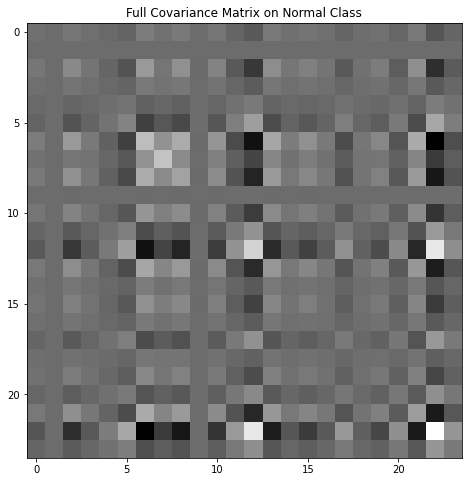

In [27]:
plt.figure()
plt.title('Full Covariance Matrix of the distribution of the features')
plt.imshow(emp_cov.covariance_)
plt.show()


In [38]:
distMahalanobis=emp_cov.mahalanobis(block1_pool_features)

In [39]:
def plot_AUC(fpr,tpf,AUC):
    lw = 2
    plt.plot(fpr, tpr, 'o',color='darkorange', label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid('on')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()